# Phân loại cổ phiếu dựa vào giá cổ phiếu

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from math import log2
from scipy.special import rel_entr
from operator import itemgetter
from vnstock import *

import cufflinks as cf
cf.go_offline()
import plotly.io as pio 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [2]:
#Liệt kê các mã chứng khoán có trên thị trường
df = listing_companies()
df.head()

,ticker,group_code,company_name,company_short_name
0,VVS,UpcomIndex,Công ty Cổ phần Đầu tư Phát triển Máy Việt Nam,Đầu tư Phát triển Máy Việt Nam
1,XDC,UpcomIndex,Công ty TNHH MTV Xây dựng Công trình Tân Cảng,Xây dựng Công trình Tân Cảng
2,HSV,UpcomIndex,Công ty Cổ phần Gang Thép Hà Nội,Gang Thép Hà Nội
3,CST,UpcomIndex,Công ty Cổ phần Than Cao Sơn - TKV,Than Cao Sơn - TKV
4,BVL,UpcomIndex,Công ty Cổ phần BV Land,BV Land


In [3]:
df.shape

(1631, 4)

In [4]:
#Tạo variable bao gồm các stock codes for analysis ở nhóm ngành Ngân hàng
a = ['BID', 'CTG', 'VCB', 'VIB', 'EIB', 'HDB', 'MBB', 'STB', 'TCB', 'TPB', 'ACB', 'LPB', 'MSB', 'OCB', 'SHB', 'SSB', 'VPB']

In [5]:
# Retrieve historical price data of any n stocks
start = "2017-01-01"
end  = dt.datetime.now().strftime("%Y-%m-%d")
empt_lists = []
for i in a:
    empt_lists.append(i)
    globals()[i] =  stock_historical_data(symbol=i, start_date=start, end_date=end).set_index('TradingDate')
empt_lists

['BID',
 'CTG',
 'VCB',
 'VIB',
 'EIB',
 'HDB',
 'MBB',
 'STB',
 'TCB',
 'TPB',
 'ACB',
 'LPB',
 'MSB',
 'OCB',
 'SHB',
 'SSB',
 'VPB']

In [6]:
# #Randomly select 10 stock codes for analysis
# a = df.sample(n=30)
# lst = a['ticker']
# lst

In [7]:
# # Retrieve historical price data of any n stocks
# start = "2017-01-01"
# end  = dt.datetime.now().strftime("%Y-%m-%d")
# empt_lists = []
# for i in lst:
#     empt_lists.append(i)
#     globals()[i] =  stock_historical_data(symbol=i, start_date=start, end_date=end).set_index('TradingDate')

In [8]:
#Chuyển từ list sang globals
empt_lists_new = empt_lists
empt_lists_new = globals()
bank_stocks = pd.concat(empt_lists_new, axis = 1, keys = empt_lists)
bank_stocks.head()

BID                                          CTG           \
                Open     High      Low    Close   Volume     Open     High   
TradingDate                                                                  
2017-01-03   10463.0  11046.0  10463.0  11046.0  4954000  10517.0  11104.0   
2017-01-04   11155.0  11447.0  11155.0  11265.0  4674470  11311.0  11448.0   
2017-01-05   11192.0  11447.0  11082.0  11228.0  1988580  11242.0  11379.0   
2017-01-06   11082.0  11702.0  11082.0  11483.0  6338280  11104.0  11793.0   
2017-01-09   11520.0  11957.0  11520.0  11811.0  6160700  11724.0  11931.0   

                                        ...  SSB                        VPB  \
                 Low    Close   Volume  ... Open High Low Close Volume Open   
TradingDate                             ...                                   
2017-01-03   10517.0  11104.0  1008370  ...  NaN  NaN NaN   NaN    NaN  NaN   
2017-01-04   11104.0  11311.0  1006570  ...  NaN  NaN NaN   NaN    NaN  NaN   
2017-01-05   11035.0  11379.0   892010  ...  NaN  NaN NaN   NaN    NaN  NaN   
2017-01-06   11104.0  11483.0  1151370  ...  NaN  NaN NaN   NaN    NaN  NaN   
2017-01-09   11586.0  11793.0  1335810  ...  NaN  NaN NaN   NaN    NaN  NaN   

                                   
            High Low Close Volume  
TradingDate                        
2017-01-03   NaN NaN   NaN    NaN  
2017-01-04   NaN NaN   NaN    NaN  
2017-01-05   NaN NaN   NaN    NaN  
2017-01-06   NaN NaN   NaN    NaN  
2017-01-09   NaN NaN   NaN    NaN  

[5 rows x 85 columns]

In [9]:
value_banks = pd.DataFrame()
for name in empt_lists:
    value_banks[name] = bank_stocks[name]['Close']
value_banks.dropna(inplace= True)

value_banks.head()

,BID,CTG,VCB,VIB,EIB,HDB,MBB,STB,TCB,TPB,ACB,LPB,MSB,OCB,SHB,SSB,VPB
TradingDate,,,,,,,,,,,,,,,,,
2021-03-24,33357.0,29495.0,73317.0,23174.0,18500.0,16320.0,17035.0,18400.0,39300.0,19962.0,20768.0,11233.0,13017.0,19080.0,11509.0,13588.0,16335.0
2021-03-25,33437.0,29798.0,73626.0,22803.0,19000.0,16384.0,17005.0,18750.0,39350.0,19925.0,20512.0,11198.0,12869.0,18840.0,11381.0,14532.0,16021.0
2021-03-26,33318.0,29533.0,73472.0,22883.0,19000.0,16480.0,16974.0,18950.0,39400.0,19777.0,20768.0,11058.0,12869.0,18840.0,12468.0,15543.0,16076.0
2021-03-29,33674.0,30251.0,73781.0,23253.0,18900.0,16640.0,17437.0,19200.0,39550.0,20295.0,21120.0,11514.0,12810.0,19160.0,13683.0,16622.0,16484.0
2021-03-30,33911.0,30554.0,73394.0,24549.0,19500.0,16768.0,17467.0,20500.0,40050.0,20591.0,21312.0,12146.0,12810.0,19280.0,15026.0,17769.0,16650.0


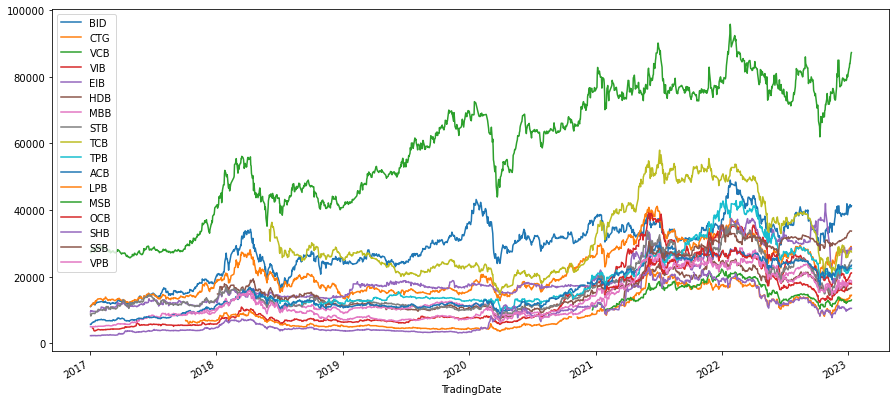

In [10]:
#Lấy giá cổ phiếu theo tuần
value_banks = value_banks.resample('W').last()
for tick in empt_lists:
    bank_stocks[tick]['Close'].plot(figsize=(15,7),label=tick)
plt.legend();

In [11]:
#Calculate rate of return (% change over time)
stoc_returns = value_banks.pct_change().fillna(method='bfill')
#pct_change(): (current row value – previous row value)/ (previous row value).
stoc_returns.head()

,BID,CTG,VCB,VIB,EIB,HDB,MBB,STB,TCB,TPB,ACB,LPB,MSB,OCB,SHB,SSB,VPB
TradingDate,,,,,,,,,,,,,,,,,
2021-03-28,0.068882,0.057597,0.030556,0.172224,0.073684,0.058252,0.076352,0.192612,0.046954,0.059918,0.067797,0.117472,0.039086,0.048832,0.384665,0.225632,0.064506
2021-04-04,0.068882,0.057597,0.030556,0.172224,0.073684,0.058252,0.076352,0.192612,0.046954,0.059918,0.067797,0.117472,0.039086,0.048832,0.384665,0.225632,0.064506
2021-04-11,-0.015556,0.029071,-0.003064,0.000000,0.100490,0.027523,0.059113,0.004425,0.008485,0.017651,-0.007215,0.031237,-0.024379,0.000000,-0.062963,-0.019475,0.021679
2021-04-18,-0.051912,-0.011760,-0.012320,0.005928,0.167038,-0.048214,-0.036693,-0.026432,-0.027644,-0.038206,-0.037791,0.044024,0.004522,-0.028340,0.019781,-0.014455,0.037062
2021-04-25,0.000000,-0.016686,0.079968,0.045102,0.028626,0.009381,0.003326,0.015837,0.001236,0.010869,0.009063,0.060734,-0.011217,-0.041667,0.046493,-0.043946,0.041860


In [12]:
stoc_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2021-03-28 to 2023-01-15
Freq: W-SUN
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BID     95 non-null     float64
 1   CTG     95 non-null     float64
 2   VCB     95 non-null     float64
 3   VIB     95 non-null     float64
 4   EIB     95 non-null     float64
 5   HDB     95 non-null     float64
 6   MBB     95 non-null     float64
 7   STB     95 non-null     float64
 8   TCB     95 non-null     float64
 9   TPB     95 non-null     float64
 10  ACB     95 non-null     float64
 11  LPB     95 non-null     float64
 12  MSB     95 non-null     float64
 13  OCB     95 non-null     float64
 14  SHB     95 non-null     float64
 15  SSB     95 non-null     float64
 16  VPB     95 non-null     float64
dtypes: float64(17)
memory usage: 13.4 KB


In [13]:
stoc_returns.isnull().sum()

BID    0
CTG    0
VCB    0
VIB    0
EIB    0
HDB    0
MBB    0
STB    0
TCB    0
TPB    0
ACB    0
LPB    0
MSB    0
OCB    0
SHB    0
SSB    0
VPB    0
dtype: int64

In [14]:
np.any(np.isnan(value_banks))
np.all(np.isfinite(value_banks))

False

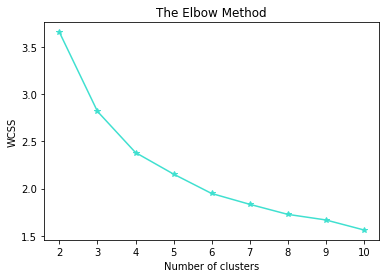

In [15]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
K = range(2, 11)
for i in K:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 5)
    kmeans.fit(stoc_returns)
    wcss.append(kmeans.inertia_)
    
plt.plot(K, wcss,color = "turquoise",marker = '*')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Clustering

In [16]:
def get_name(symbol):
    return df['company_short_name'][df['ticker']==symbol].values
    
def plot_stock(symbol, stocks=value_banks):
    stocks[symbol].plot(title=symbol, label=symbol, alpha=0.9);
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(stoc_returns.T);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(stoc_returns.T)):
    clusters[l].append(stoc_returns.columns[i])
    
for c in sorted(clusters):
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol), '(' + symbol + ')', end='; ')
    print()
    print()

Cluster 0: ['BIDV'] (BID); ['VietinBank'] (CTG); ['Vietcombank'] (VCB); ['VIBBank'] (VIB); ['HDBank'] (HDB); ['MBBank'] (MBB); ['Sacombank'] (STB); ['Techcombank'] (TCB); ['Ngân hàng Tiên Phong'] (TPB); ['Ngân hàng Á Châu'] (ACB); ['LienViet Post Bank'] (LPB); ['MSB Bank'] (MSB); ['Ngân hàng Phương Đông'] (OCB); ['VPBank'] (VPB); 

Cluster 1: ['SHB'] (SHB); 

Cluster 2: ['Eximbank'] (EIB); ['SeABank'] (SSB); 



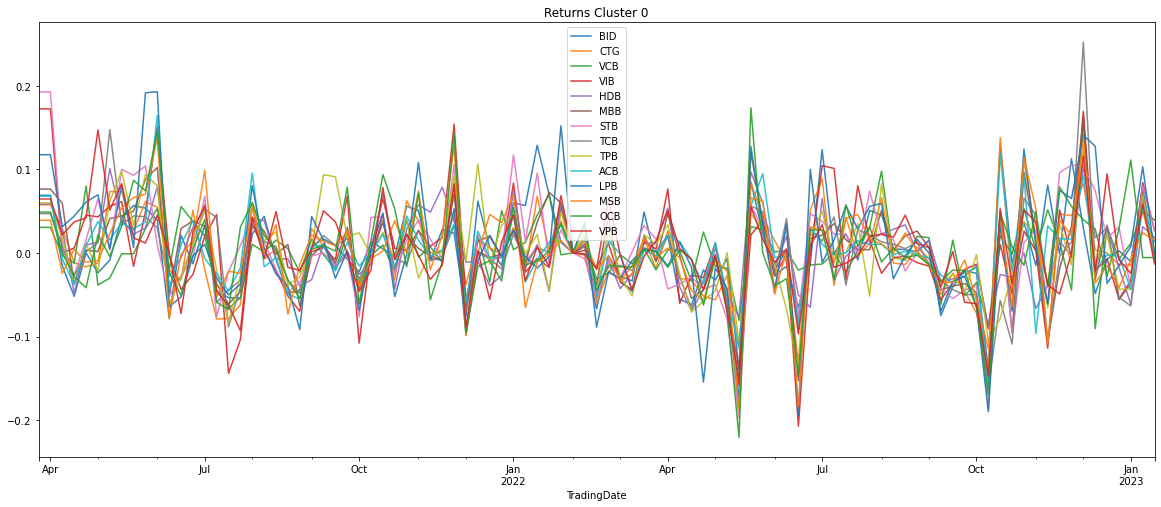

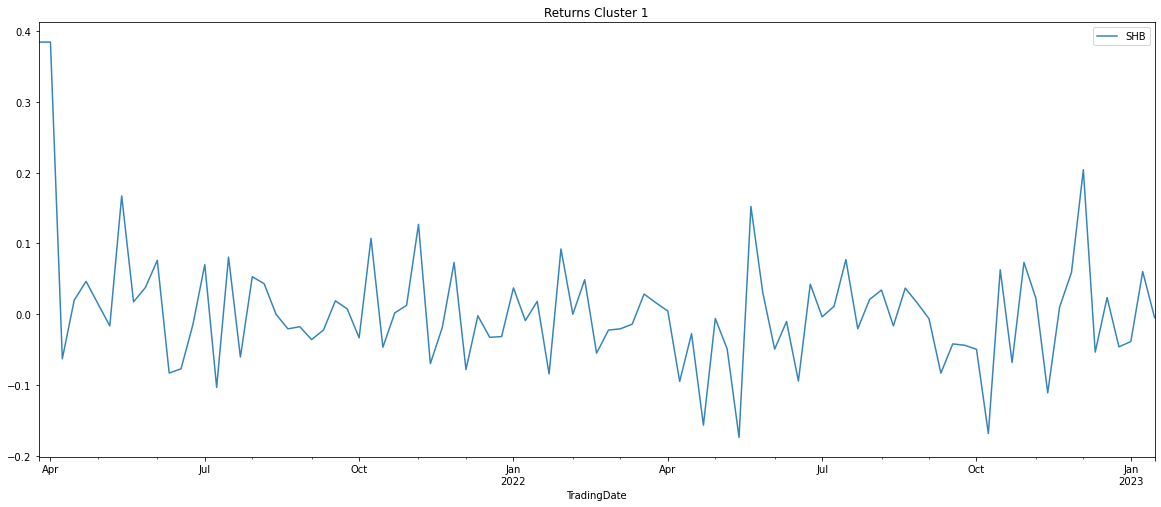

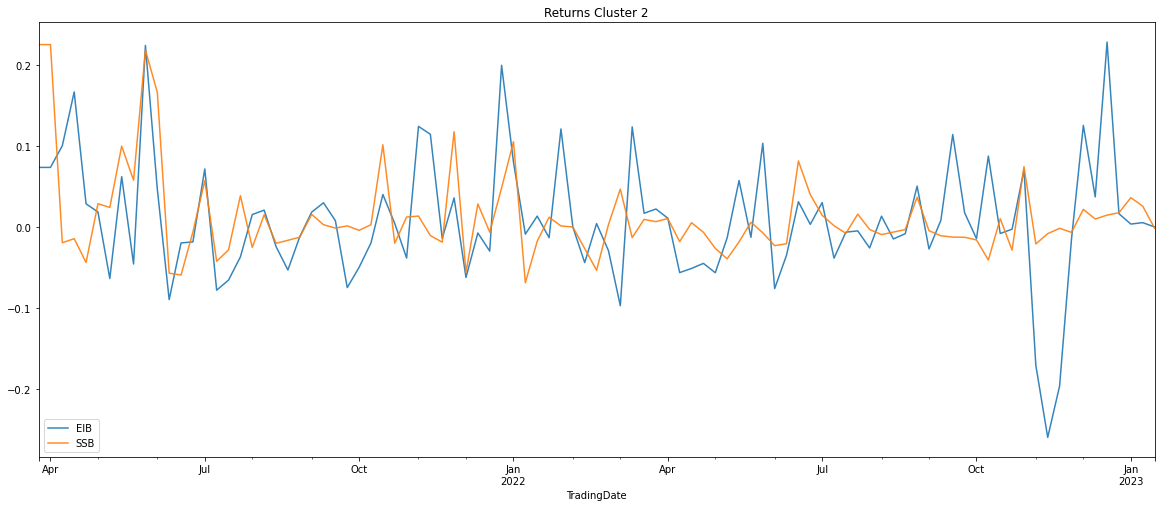

In [17]:
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=stoc_returns)
    plt.title('Returns Cluster ' + str(c))
    plt.legend()
    plt.show()


# Principal Components Analysis and Clustering

In [18]:
pca = PCA(n_components=.5, random_state=10)
components = pca.fit_transform(stoc_returns.T)
print('Number of PCA components', components.shape[1])
print('PCA explained variance ratio:', pca.explained_variance_ratio_)
print('PCA total explained variance: ', np.sum(pca.explained_variance_ratio_))

Number of PCA components 3
PCA explained variance ratio: [0.2496603  0.17912791 0.10410894]
PCA total explained variance:  0.5328971457955183


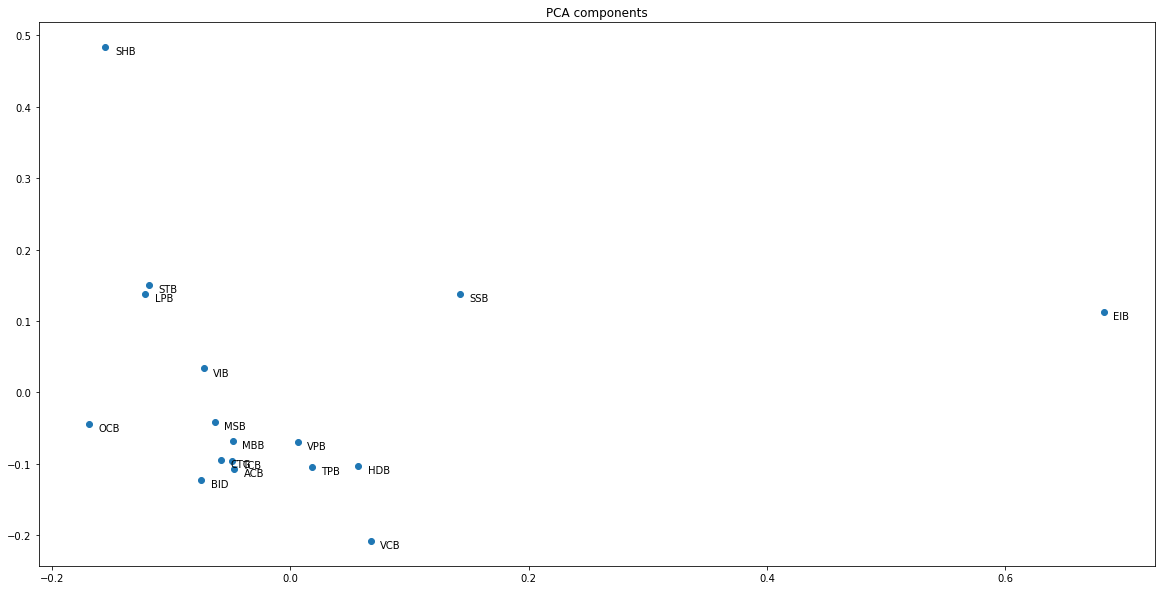

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1])
for i in range(components.shape[0]):
    plt.text(x=components[i,0]+0.008, y=components[i,1]-0.01, s=stoc_returns.columns[i])
plt.title('PCA components');


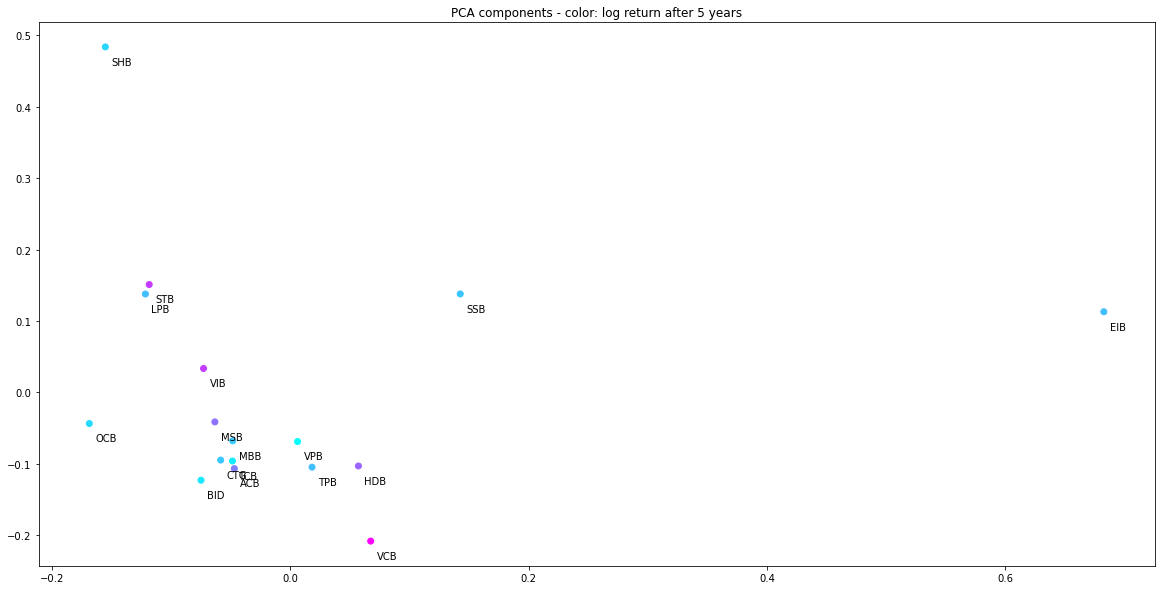

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1],  c = stoc_returns.iloc[-1].T.apply(np.log1p), cmap='cool')
for i in range(components.shape[0]): 
    plt.text(x=components[i,0]+0.005, y=components[i,1]-0.025, s=stoc_returns.columns[i])
plt.title('PCA components - color: log return after 5 years');

In [21]:
print('Number of dimensions for clustering with PCA: ', len(components.T))

Number of dimensions for clustering with PCA:  3


In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(components);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(components)):
    clusters[l].append(value_banks.columns[i])
    
for c in clusters:
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end='; ')
    print()
    print()

Cluster 0: ['Sacombank (STB)']; ['LienViet Post Bank (LPB)']; ['SHB (SHB)']; ['SeABank (SSB)']; 

Cluster 1: ['BIDV (BID)']; ['VietinBank (CTG)']; ['Vietcombank (VCB)']; ['VIBBank (VIB)']; ['HDBank (HDB)']; ['MBBank (MBB)']; ['Techcombank (TCB)']; ['Ngân hàng Tiên Phong (TPB)']; ['Ngân hàng Á Châu (ACB)']; ['MSB Bank (MSB)']; ['Ngân hàng Phương Đông (OCB)']; ['VPBank (VPB)']; 

Cluster 2: ['Eximbank (EIB)']; 



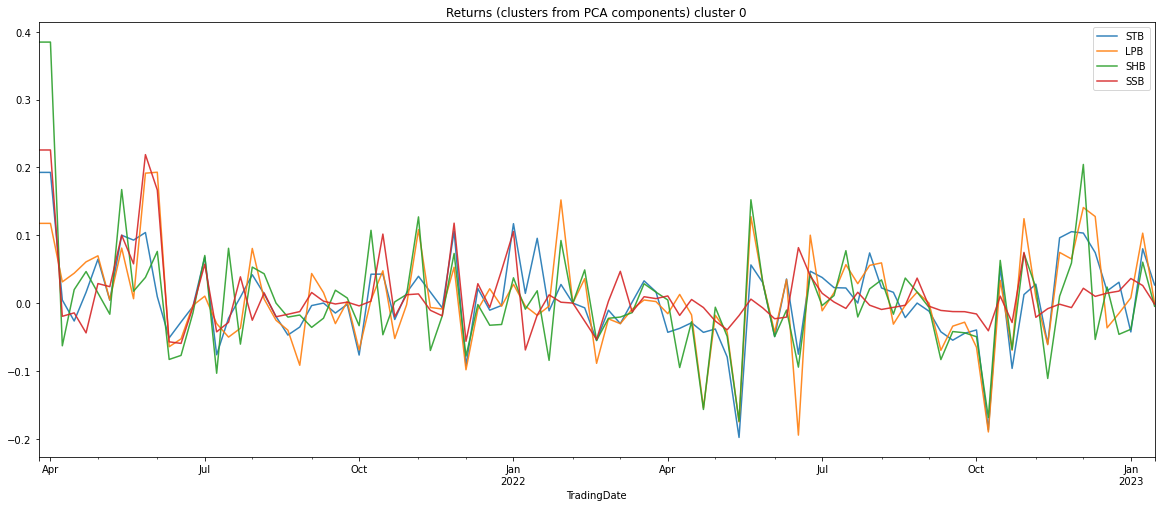

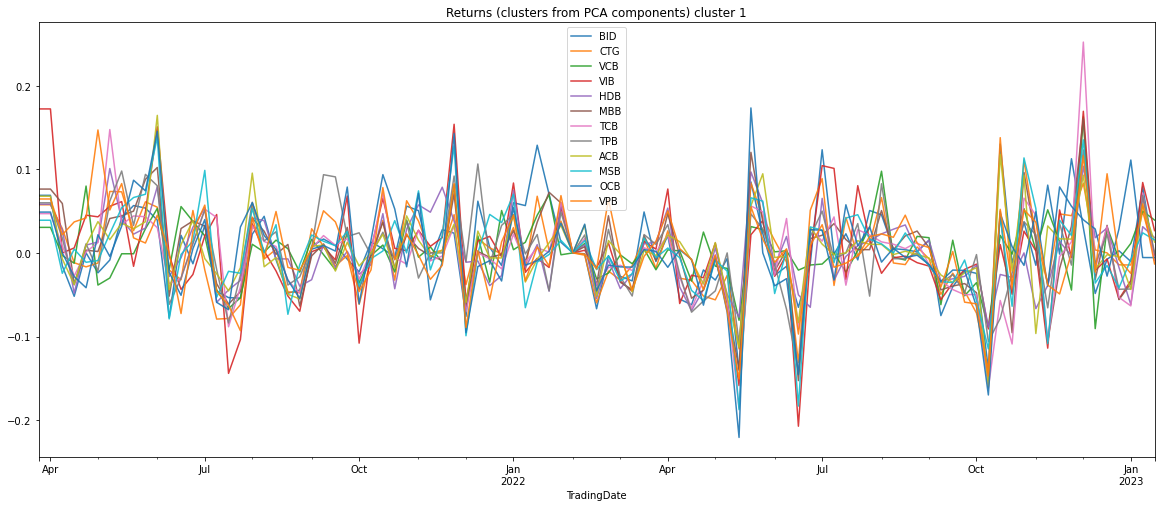

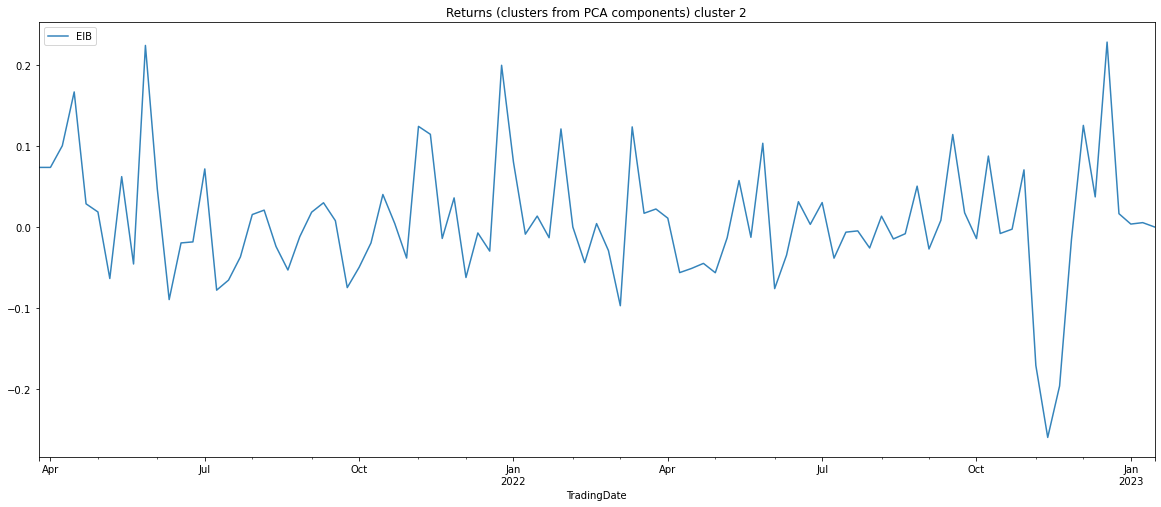

In [23]:
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=stoc_returns)
    plt.title('Returns (clusters from PCA components) cluster ' + str(c))
    plt.legend()
plt.show()


# Gaussian Mixture model

In [24]:
#Lấy các mã cổ phiếu của VNINDEX group
lst_vnindex = df['ticker'][df['group_code']=='VNINDEX']
lst_vnindex.unique()

array(['FUCTVGF3', 'FUEIP100', 'GMH', 'FUEKIV30', 'NO1', 'FUCTVGF4',
       'FUEDCMID', 'FUEKIVFS', 'AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT',
       'ACB', 'ACC', 'ACL', 'AGM', 'AGR', 'AGG', 'AMD', 'ACG', 'ANV',
       'APC', 'APG', 'APH', 'HII', 'ASG', 'ASM', 'ASP', 'BAF', 'BBC',
       'BCE', 'BCG', 'BFC', 'BHN', 'BIC', 'BID', 'BCM', 'DBD', 'BWE',
       'BKG', 'BMC', 'BMI', 'BMP', 'BRC', 'BSI', 'BTP', 'BTT', 'BVH',
       'TNH', 'C32', 'C47', 'CAV', 'CCI', 'CCL', 'CDC', 'CRE', 'STK',
       'CHP', 'CIG', 'CII', 'CKG', 'CLC', 'ADG', 'CLL', 'CLW', 'CMG',
       'CMV', 'CMX', 'CNG', 'COM', 'CRC', 'CSM', 'CSV', 'CTD', 'CTF',
       'CTG', 'CTI', 'ICT', 'CTR', 'CTS', 'CVT', 'D2D', 'DAG', 'DAH',
       'ADS', 'DPG', 'DBC', 'DBT', 'DC4', 'DCL', 'DCM', 'DGC', 'DGW',
       'DHA', 'DHC', 'DHG', 'DHM', 'TTE', 'DIG', 'DLG', 'DMC', 'DPM',
       'DPR', 'DQC', 'DRC', 'DRH', 'DRL', 'DSN', 'DTA', 'DTL', 'DTT',
       'DVP', 'DXG', 'DXS', 'DXV', 'FUESSV50', 'E1VFVN30', 'EIB', 'ELC',
       'EMC', '

In [25]:
len(lst_vnindex)

417

In [26]:
start = "2017-01-01"
end  = dt.datetime.now().strftime("%Y-%m-%d")
empt_lists_b = []
for i in lst_vnindex:
    empt_lists_b.append(i)
    globals()[i] =  stock_historical_data(symbol=i, start_date=start, end_date=end).set_index('TradingDate')

In [27]:
empt_lists_new_b = empt_lists_b
empt_lists_new_b = globals()
bank_stocks_b = pd.concat(empt_lists_new_b, axis = 1, keys = empt_lists_b)
bank_stocks_b.tail()

FUCTVGF3                                   FUEIP100          \
                Open     High      Low    Close Volume     Open    High   
TradingDate                                                               
2023-01-04   16800.0  16800.0  16800.0  16800.0    0.0   7450.0  7520.0   
2023-01-05   16800.0  16800.0  16800.0  16800.0    0.0   7440.0  7520.0   
2023-01-06   16800.0  16800.0  16800.0  16800.0    0.0   7560.0  7600.0   
2023-01-09   16800.0  16800.0  16800.0  16800.0    0.0   7490.0  7580.0   
2023-01-10   16800.0  16800.0  16800.0  16800.0    0.0   7470.0  7540.0   

                                      ...     YBM                          \
                Low   Close   Volume  ...    Open    High     Low   Close   
TradingDate                           ...                                   
2023-01-04   7410.0  7430.0  43500.0  ...  5750.0  5780.0  5750.0  5780.0   
2023-01-05   7420.0  7490.0  45900.0  ...  5800.0  5800.0  5700.0  5780.0   
2023-01-06   7480.0  7480.0  41399.0  ...  5690.0  5780.0  5690.0  5780.0   
2023-01-09   7490.0  7520.0  46600.0  ...  5780.0  5850.0  5700.0  5780.0   
2023-01-10   7470.0  7520.0  48600.0  ...  5780.0  5780.0  5700.0  5710.0   

                        YEG                                    
             Volume    Open    High     Low   Close    Volume  
TradingDate                                                    
2023-01-04   2293.0  9210.0  9710.0  9210.0  9350.0   63250.0  
2023-01-05   1600.0  9480.0  9480.0  8700.0  8700.0  296200.0  
2023-01-06   1500.0  9140.0  9150.0  8600.0  8890.0   87242.0  
2023-01-09   2040.0  8890.0  8980.0  8420.0  8720.0   84100.0  
2023-01-10   7701.0  8750.0  8840.0  8450.0  8620.0   63612.0  

[5 rows x 2085 columns]

In [28]:
value_banks_b = pd.DataFrame()
for name in empt_lists_b:
    value_banks_b[name] = bank_stocks_b[name]['Close']
value_banks_b.dropna(inplace= True)

#Calculate profit margin
vnindex_returns_b = value_banks_b.pct_change().fillna(method='bfill')
vnindex_returns_b.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4884\2427762369.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,FUCTVGF3,FUEIP100,GMH,FUEKIV30,NO1,FUCTVGF4,FUEDCMID,FUEKIVFS,AAA,AAM,...,VPI,VRC,VRE,VSC,VSH,VSI,VTB,VTO,YBM,YEG
TradingDate,,,,,,,,,,,,,,,,,,,,,
2022-11-28,0.0,0.018545,-0.007092,0.003072,-0.047847,0.017382,0.042216,0.005063,0.000000,0.000000,...,0.012069,0.030683,0.040956,-0.003106,0.022581,0.061810,-0.008403,0.000000,0.017889,0.005488
2022-11-29,0.0,0.018545,-0.007092,0.003072,-0.047847,0.017382,0.042216,0.005063,0.000000,0.000000,...,0.012069,0.030683,0.040956,-0.003106,0.022581,0.061810,-0.008403,0.000000,0.017889,0.005488
2022-11-30,0.0,0.015406,-0.007143,0.062787,-0.045226,-0.069347,0.012658,0.036524,0.020270,0.049774,...,0.039182,-0.037889,0.001639,-0.017134,-0.006309,0.000000,0.008475,0.001342,0.001757,-0.013100
2022-12-01,0.0,0.001379,-0.014388,-0.017291,-0.052632,-0.069114,0.005000,0.003645,0.006623,0.000000,...,-0.001639,0.054852,-0.018003,0.012678,-0.006349,-0.047598,-0.008403,0.005362,0.049123,0.069690
2022-12-02,0.0,0.038567,-0.003650,0.043988,0.000000,-0.069606,0.044776,0.056901,0.036842,0.038793,...,-0.014778,-0.001333,0.051667,0.003130,0.000000,0.000000,0.000000,0.006667,-0.013378,0.065150


In [29]:
scaler = StandardScaler();
scaled_df = scaler.fit_transform(vnindex_returns_b.T);
normalized_df = normalize(scaled_df);
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

,P1,P2
0,0.514731,-0.066341
1,-0.376769,0.554000


In [30]:
gmm = GaussianMixture(n_components = 3) 
gmm.fit(X_principal)

GaussianMixture(n_components=3)

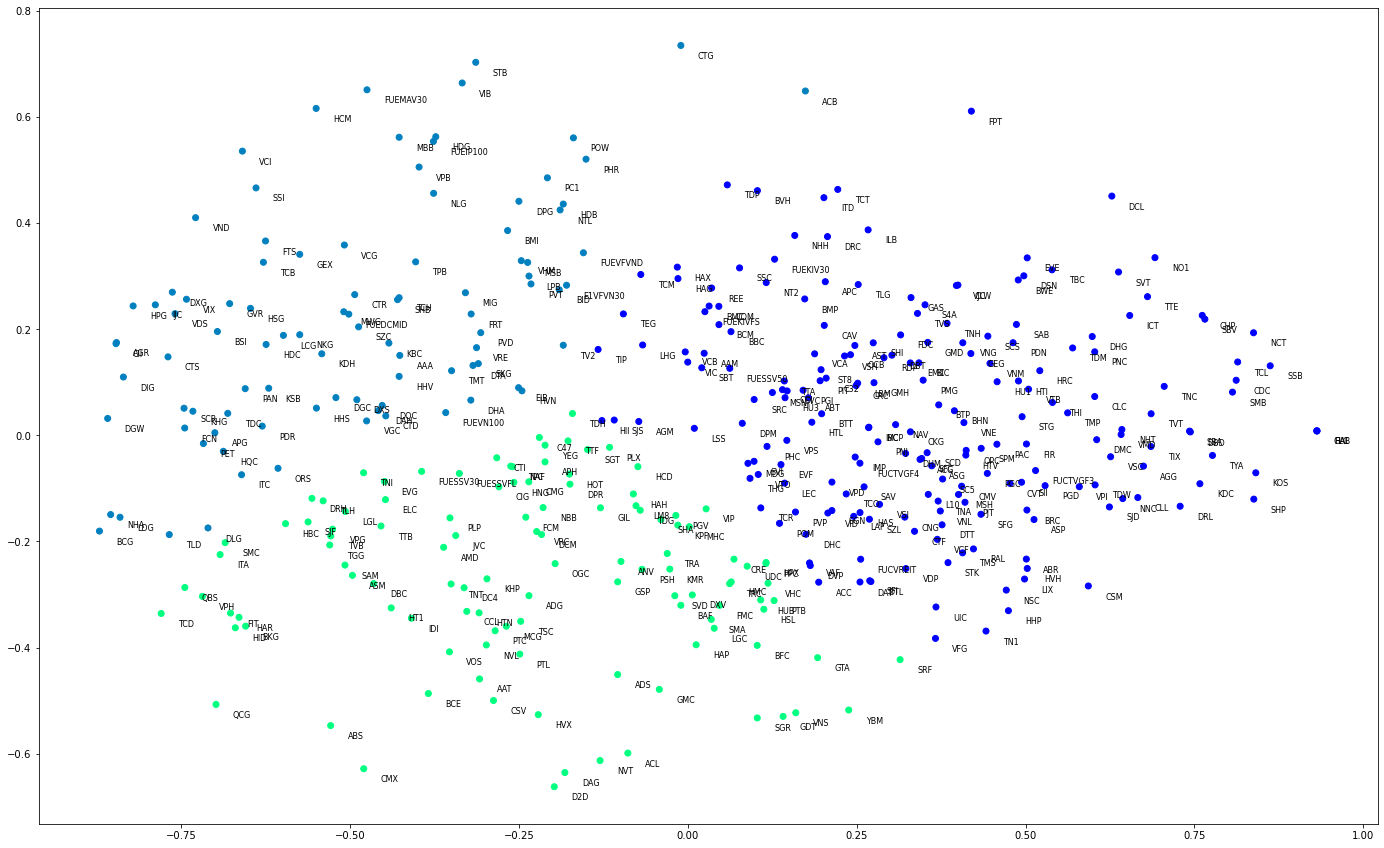

In [31]:
plt.figure(figsize=(24,15))
plt.scatter(X_principal['P1'], X_principal['P2'],  
            c = GaussianMixture(n_components = 3).fit_predict(X_principal), alpha = 1, cmap='winter') 
for i in range(X_principal.shape[0]):
    plt.text(x=X_principal['P1'][i]+0.025, y=X_principal['P2'][i]-0.025, s=vnindex_returns_b.columns[i], fontsize=8)
plt.show() 

# KullBack Leibler để tìm danh mục gần bằng với VNINDEX

In [47]:
#Chuyển về dưới dạng phân phối sác xuất ([0,1])
def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

In [48]:
vnindex_returns_b = softmax(vnindex_returns_b)

In [49]:
len(vnindex_returns_b)

29

In [50]:
list_sum, idx = [], []
for i in vnindex_returns_b.columns:
    tong = 0
    for j in vnindex_returns_b.columns:
        kl_pq = sum(rel_entr(list(vnindex_returns_b[i].values), list(vnindex_returns_b[j].values)))
        tong += kl_pq
    idx.append(i)
    list_sum.append(tong)
dic_KL = dict(zip(idx, list_sum))

In [45]:
#Cổ phiếu #K gần bằng(xấp xỉ) VNINDEX
K=30
dict(sorted(dic_KL.items(), key = itemgetter(1))[:K])

{'FUEIP100': 0.17906069316954695,
 'E1VFVN30': 0.18512822953816213,
 'BCM': 0.1906439654529453,
 'FUEVFVND': 0.19070561186863075,
 'FUEMAV30': 0.19070736912904562,
 'SJD': 0.1953966179448809,
 'DRC': 0.19616631198428716,
 'KOS': 0.19669784720404215,
 'CDC': 0.19745820859391403,
 'RAL': 0.19802629639348296,
 'DPR': 0.19822943995087022,
 'SSB': 0.19877991687414145,
 'DMC': 0.20024153659150226,
 'HVH': 0.20263069657535218,
 'FUESSVFL': 0.2035999241505572,
 'FPT': 0.20401616496701913,
 'ASP': 0.20494238950744056,
 'HTI': 0.2056076249011129,
 'FIR': 0.2072284336046629,
 'REE': 0.20783949770446697,
 'MSB': 0.20874441088997664,
 'VJC': 0.2089918664587746,
 'FLC': 0.2092245556113489,
 'GAB': 0.2092245556113489,
 'HAI': 0.2092245556113489,
 'DRL': 0.20990916976718563,
 'CLL': 0.21119103374131926,
 'SMB': 0.21261294099223063,
 'FUEKIVFS': 0.21284809230289606,
 'HAX': 0.2146396039932018}